
# Time series analysis
 Lund University

### Example code 4: examining the US Tobacco data (see also Ex 4.17).

**Reference:**  
*An Introduction to Time Series Modeling*, 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

Lets have fun!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, stats
from scipy.stats import chi2

# import tsa library
import os
import sys
sys.path.append(os.path.join('..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main'))

from tsa_lth.analysis import acf, pacf, plotACFnPACF, pzmap
from tsa_lth.tests import monti_test, test_mean
from tsa_lth.modelling import PEM

# Configure matplotlib 
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.0


### Plot the examined data

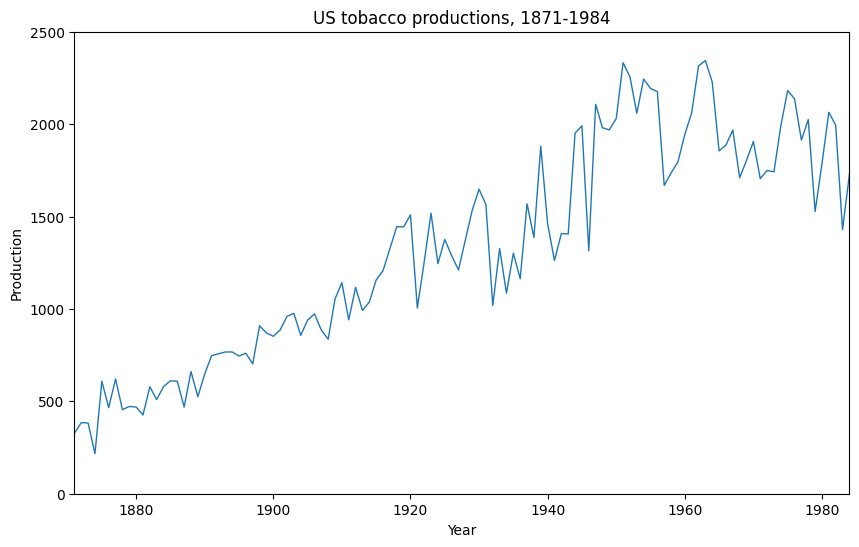

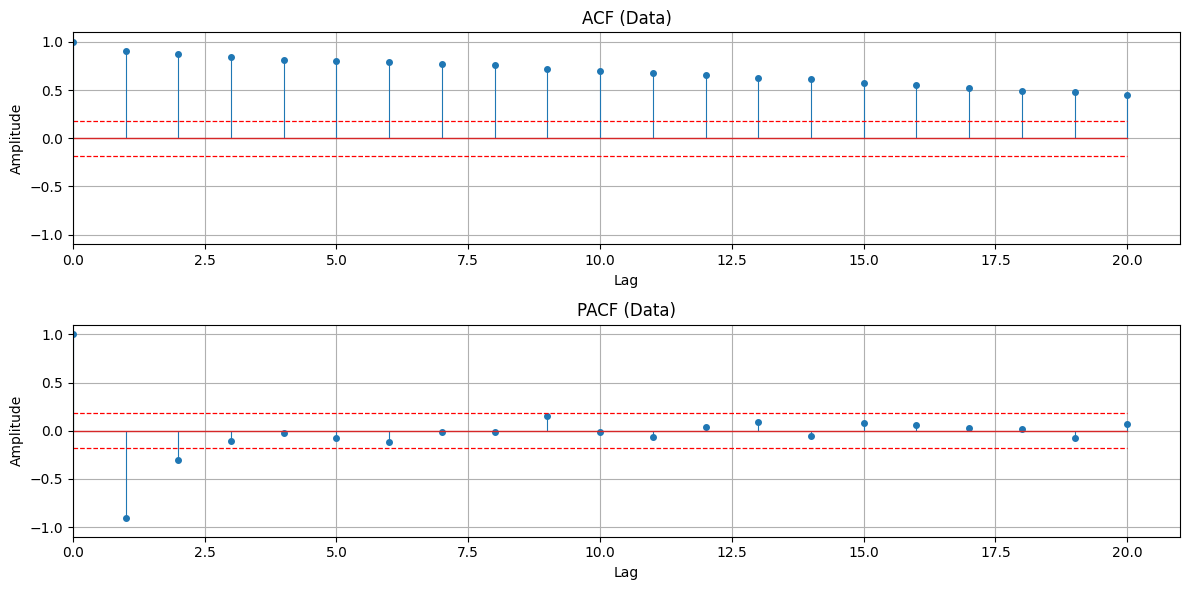

In [2]:
# Plot the examined data. 
signLvl = 0.05
noLags = 20

# Load tobacco data (equivalent to dataTobacco.m)
df = pd.read_csv('../data/tobacco_data.csv')
# Ensure data is float 
data = df['production'].astype(float).values
data = data 

plt.figure(1)
time = np.arange(1871, 1985)  # 1871:1984 in MATLAB
plt.plot(time, data)
plt.axis([time[0], time[-1], 0, 2500])  
plt.xlabel('Year')
plt.ylabel('Production')
plt.title('US tobacco productions, 1871-1984') 
plt.show()

plotACFnPACF(data, noLags, 'Data')  # We do this so often, lets add a function for it.

### There seems to be a linear trend in the data. Estimate this and remove its influence.

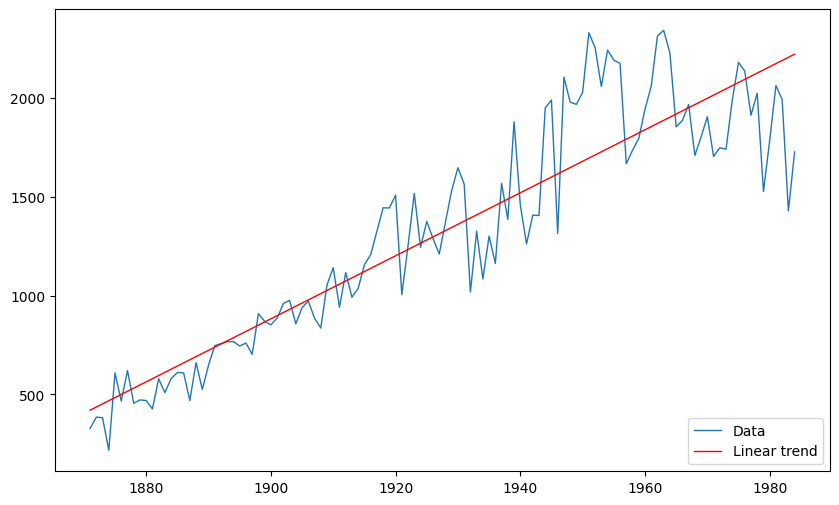

In [3]:
N = len(data)
X = np.column_stack([np.ones(N), np.arange(1, N+1)])  # [ ones(N,1) (1:N)' ] in MATLAB
theV = np.linalg.inv(X.T @ X) @ X.T @ data  # inv( X'*X )*X'*data; This is the least-squares estimate of the trend. More on this later.
z = data - theV[0] - theV[1]*np.arange(1, N+1)  # Subtract the estimated trend.

# Add the estimated trend to the plot.
plt.figure(1)
plt.hold = True 
plt.plot(time, data, label='Data')
plt.plot(time, theV[0] + theV[1]*np.arange(1, N+1), 'r', label='Linear trend')
plt.legend(['Data', 'Linear trend'], loc='lower right')  # legend('Data', 'Linear trend', 'Location', 'SE')
# hold off equivalent is automatic in matplotlib
plt.show()

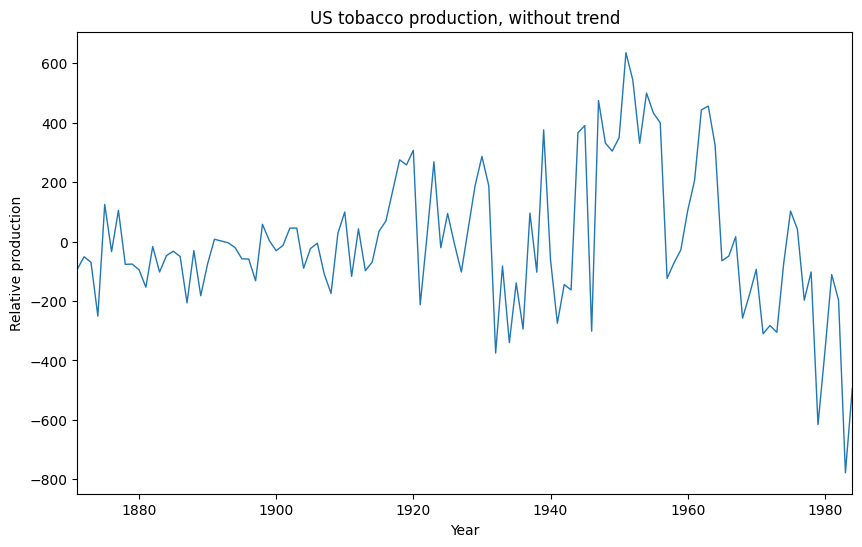

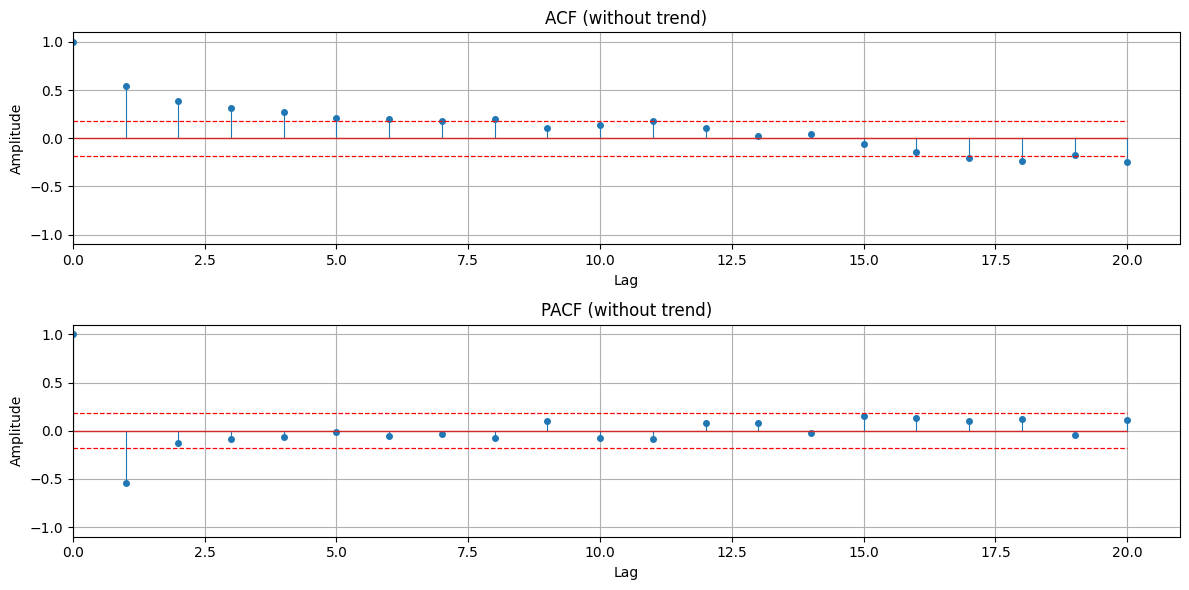

In [4]:
# Plot the resulting de-trended data and its ACF and PACF.
plt.figure()
plt.plot(time, z)
plt.xlim([time[0], time[-1]])
plt.xlabel('Year')
plt.ylabel('Relative production')
plt.title('US tobacco production, without trend')
plt.show()

plotACFnPACF(z, noLags, 'without trend')

### Try differentiating the data instead. Which seems to remove the trend best?

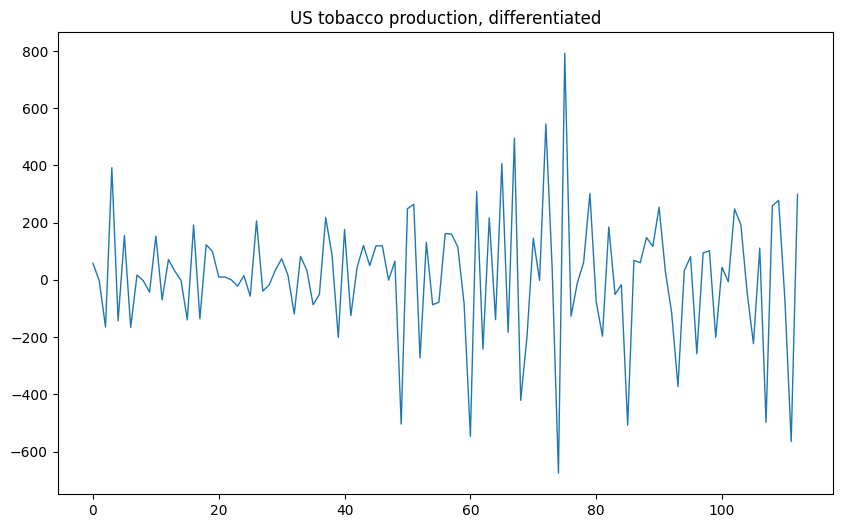

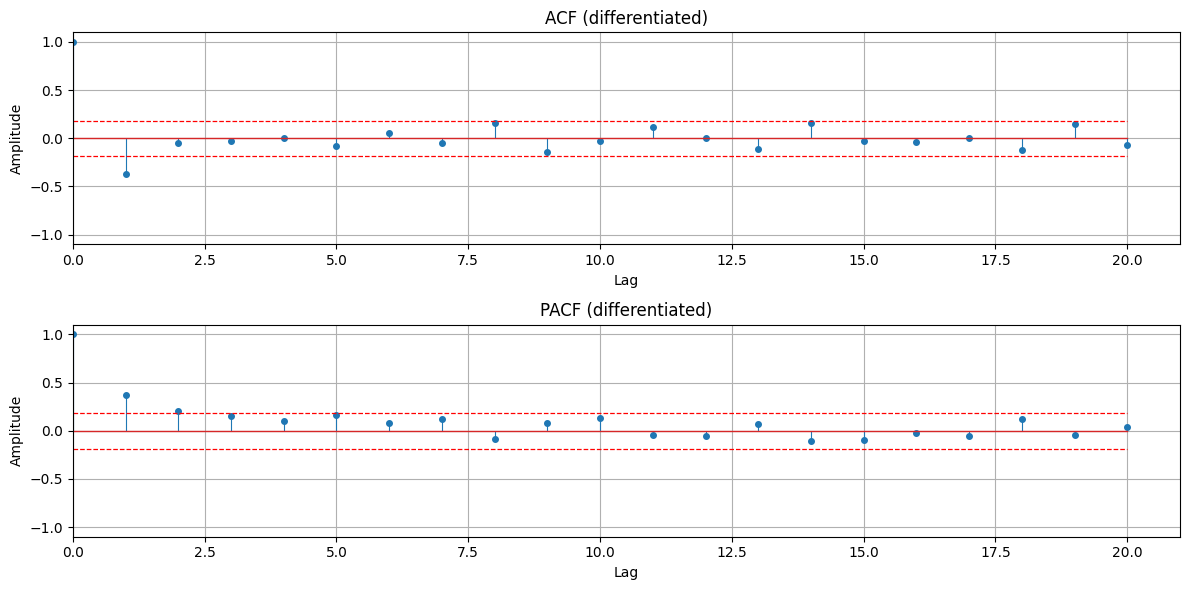

In [5]:
y = signal.lfilter([1, -1], 1, data)  # filter([1 -1], 1, data) in MATLAB
y = y[1:]  # y = y(2:end); Why should one remove the p first samples when filtering with a p:th order filter? Look at code5!

# Plot the resulting de-trended data and its ACF and PACF.
plt.figure()
plt.plot(y)
plt.title('US tobacco production, differentiated')
plt.show()

plotACFnPACF(y, noLags, 'differentiated')

## Try estimating a model for the differentiated data.

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 + 0.3714(±0.0883)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 6.51%
FPE : 44004.377  MSE : 43470.315
AIC : 1515.984   BIC : 1518.702



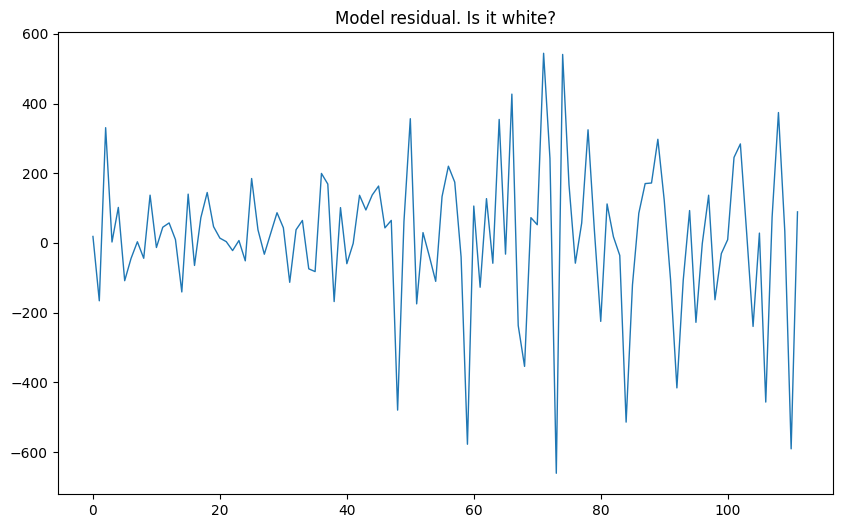

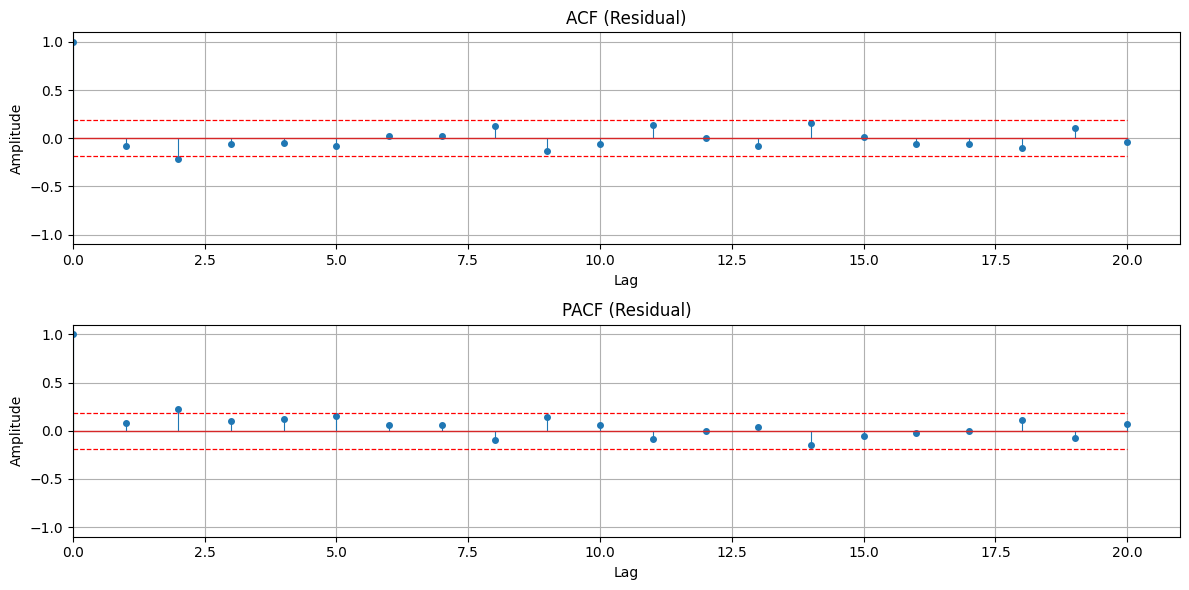

A polynomial with differentiation: [ 1.         -0.62860272 -0.37139728]

The variance of original data is       331644.33.
The variance explained by the model is 288418.79.
The model explains 86.97 % of the data.


In [6]:
# Estimate unknown parameters using PEM (Prediction Error Minimization)
Am = np.array([1, 1])  # Specify assumed model orders.
Cm = np.array([1])

# You can also use the non-differentiated data (z). How does the resulting
#Am = np.convolve(Am, [1, -1])  # Include the differentiation in the A polynomial.

# Estimate unknown parameters using PEM (more on this later).
pem_model = PEM(y, A=Am, C=Cm)
foundModel = pem_model.fit()

print(foundModel.summary(return_val=True)) # The confidence interval is +/- one std, i.e., 68% confidence interval.

# Compute the residual. Remember to remove the initial samples.
ey = signal.lfilter(foundModel.A, 1, y)
# MATLAB: ey = ey(length(foundModel.A):end );  -> Python keep from len(foundModel.A)-1
ey = ey[len(foundModel.A)-1:] 

# Plot the ACF and PACF.
plt.figure()
plt.plot(ey)
plt.title('Model residual. Is it white?')
plt.show()

plotACFnPACF(ey, noLags, 'Residual')

# With the differentiation, the found A-polynomial is:
print(f"A polynomial with differentiation: {np.convolve(foundModel.A, [1, -1])}")

# The variance of the residual is a measure for how well the model fits the
# data. How much of the data did we manage to explain?
print(f"\nThe variance of original data is       {np.var(data):.2f}.")
print(f"The variance explained by the model is {np.var(data)-np.var(ey):.2f}.")
print(f"The model explains {100*(np.var(data)-np.var(ey))/np.var(data):.2f} % of the data.")

## Does the data seem to be white? More on this later.
Is the residual white? Lets examine the Monti test.

In [7]:
deemedWhite, Q, chiV = monti_test(ey)  
if deemedWhite:
    print(f'The residual is deemed to be WHITE according to the Monti-test (as {Q:5.2f} < {chiV:5.2f}).')
else:
    print(f'The residual is NOT deemed to be white according to the Monti-test (as {Q:5.2f} > {chiV:5.2f}).')

The residual is deemed to be WHITE according to the Monti-test (as 25.28 < 31.41).


# Does the residual have a mean that is different from zero?

In [8]:
# Does the residual have a mean that is different from zero?
reject, tRatio_v, tLimit_v = test_mean(ey, return_val=True)

if reject:
    print(f'The data is not deemed to be zero-mean (as {tRatio_v:6.4f} > {tLimit_v:6.4f}). ')
else:
    print(f'The data is deemed to be zero-mean (as {tRatio_v:6.4f} < {tLimit_v:6.4f}). ' )


Mean of data IS deemed to be 0!
The data is deemed to be zero-mean (as 0.6286 < 3.9266). 
